In [5]:
import torch
import fairseq

In [6]:
from fairseq.models import FairseqEncoder, FairseqEncoderDecoderModel

from fairseq.models.fconv import (
    Embedding,
    PositionalEmbedding,
    FConvDecoder
)
from torch.distributions import Normal


from restorant_dataset import RestDataset, lines_generator
from torchtext import data

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# net.to(device)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torch.utils.tensorboard import SummaryWriter


torch.manual_seed(100)

In [8]:
class NoEncoder(FairseqEncoder):
    """
    The input contain:
        sequence of latent embedding indecies
        class index (positive / negative)
        embed the input and noise the sample embeddings.
    """
    def __init__(self, sample_size, padding_index, ntokens=5, embed_dim=512, noise_std=0.1, dropout=0.1):
        """
        number of latent-space tokens is constant.
        """
        super().__init__(None)
        self.dropout = dropout
        self.dim = embed_dim
        self.ntokens = ntokens
        
        self.content_embeddings = Embedding(sample_size, embed_dim * ntokens, padding_index) # tokens-encoder, sample-specific
        
        self.negative_embedding = PositionalEmbedding(num_embeddings=ntokens+1, 
                                                     embedding_dim=embed_dim, 
                                                     padding_idx=0)
        
        self.positive_embedding = PositionalEmbedding(num_embeddings=ntokens+1, 
                                                     embedding_dim=embed_dim, 
                                                     padding_idx=0)
        
        self.noise = Normal(loc=0.0, scale=noise_std)
        
    def forward(self, src_tokens, src_lengths):
        """
        src_tokens are two: one for the sentiment (0 or 1),
                            and one for the sample [0.. sample_size]
                            shape is always (batch, 2)
        src_lengths is (batch)-size array full of 2.
        """
        
        batch_size = src_tokens.size()[0]
        
        # content embedding and noise
        content = self.content_embeddings(src_tokens[:, 0])
#         print('src_tokens.size(): {}'.format(src_tokens.size()))
#         print('content.size(): {}'.format(content.size()))
#         print('dim: {}'.format(self.dim))
#         print('ntokens: {}'.format(self.ntokens))
        content = content.view(batch_size, self.ntokens, self.dim)
        content = content + self.noise.sample(sample_shape=content.size()).to(device)
        
        # sentiment positional embedding
        positions = torch.arange(1, self.ntokens+1).unsqueeze(0).to(device) # 1 x ntokens
        sentiment = src_tokens[:, 1].unsqueeze(1).unsqueeze(2) # batch x 1 x 1
#         print(src_tokens[:, 1])
        
#         print(positions)
#         print(self.positive_embedding)
#         print(self.positive_embedding(positions))
        
        
        a = self.positive_embedding(positions)
        
        b = self.negative_embedding(positions)
        
        sentiment = self.positive_embedding(positions) * sentiment + \
                     self.negative_embedding(positions) * (torch.tensor(1) - sentiment) # batch x ntokens x dim
        print(sentiment)
        
        x = content + sentiment
        x = F.dropout(x, p=self.dropout, training=self.training)
#         x = x.permute(1, 0, 2)
#         print('shape of encoder output is {}'.format(x.size()))
        return {
            'encoder_out': (x,x),
            'encoder_padding_mask': None
        }
        


In [9]:
class NoEncoderFConvDecoderModel(FairseqEncoderDecoderModel):
    """
    encoder-decoder that use the no-encoder as encoder and the fconv decoder as decoder.
    inspiration from fconv.py
    """
    def __init__(self, encoder, decoder):
        super().__init__(encoder, decoder)

In [10]:
def get_dataset(max_examples):
    g = lines_generator()

    id_f = data.Field(sequential=False, use_vocab=False)
    stars_f = data.Field(sequential=False, use_vocab=False)
    review_f = data.Field(sequential=True, use_vocab=True)

    dataset = RestDataset(g, id_f, stars_f, review_f, max_examples)

    review_f.build_vocab(dataset)
    
    return dataset, review_f.vocab

nsamples = 300000
dataset, vocab = get_dataset(nsamples)

290255it [00:02, 111975.66it/s]


In [11]:
batch_size = 7
iterations_per_epoch = nsamples // batch_size
print(iterations_per_epoch)
print(len(vocab))
train_iter = data.BucketIterator(
        dataset=dataset, batch_size=batch_size,
        sort_key = lambda x: len(x.review), sort=True, repeat=True)

42857
9546


In [12]:
def checkpoint(model, path='/cs/labs/dshahaf/omribloch/train/text_lord/checkpoint_fconv.txt'):
#     Save:
    if os.path.exists(path):
        os.remove(path)
    torch.save(model.state_dict(), path)
    print('saved checkpoint!')

def load_checkpoint(path='/cs/labs/dshahaf/omribloch/train/text_lord/checkpoint_fconv.txt'):
#     Load:
    model = TheModelClass(*args, **kwargs)
    model.load_state_dict(torch.load(PATH))
    model.eval()

In [13]:
from tqdm import tqdm_notebook

decoder_dictionary = fairseq.data.dictionary.Dictionary()
for i in tqdm_notebook(range(len(vocab))):
    decoder_dictionary.add_symbol(vocab.itos[i])

Widget Javascript not detected.  It may not be installed or enabled properly.


In [14]:
dim = 16
encoder = NoEncoder(nsamples, decoder_dictionary.pad(), embed_dim=dim)
# (self, sample_size, padding_index, ntokens=5, embed_dim=512, noise_std=0.1, dropout=0.1)
decoder = FConvDecoder(decoder_dictionary, dim, None, dim, 20, ((dim, 3),) * 10)

# #self, dictionary, embed_dim=512, embed_dict=None, out_embed_dim=256,
#         max_positions=1024, convolutions=((512, 3),) * 20, attention=True,
#         dropout=0.1, share_embed=False, positional_embeddings=True,
#         adaptive_softmax_cutoff=None, adaptive_softmax_dropout=0,

In [15]:
model = NoEncoderFConvDecoderModel(encoder, decoder)
model = model.to(device)

In [16]:
PAD = decoder_dictionary.pad()

loss_function = F.cross_entropy
# for parameter in model.parameters():
#     torch.nn.utils.clip_grad.clip_grad_value_(parameter, 0.1)
# optimizer = optim.Adagrad(model.parameters())
# optimizer_2 = optim.SGD(encoder.content_embeddings.parameters(), 0.1, weight_decay=0.001)




optimizer = optim.SGD(model.parameters(), lr=0.25, momentum=0.99, nesterov=True)




def shift_left(tensor, padding_value):
    """
    tensor is 2-d, (sequence, batch)
    we are shifting the sequence and we will get (sequence+1, batch)
    """
    assert len(tensor.size()) == 2
    new_tensor = torch.full(tensor.size(), padding_value, dtype=torch.int64)
    new_tensor[0:-1, :] = tensor[1:, :]
    return new_tensor


# training loop
from tqdm import tqdm_notebook
import numpy as np
losses = []
writer = SummaryWriter(comment=' 2 optimizers with decay')
for i, batch in tqdm_notebook(enumerate(train_iter)):
    
    rbatch_size = batch.id.size()[0]
#     print(rbatch_size)
    
    ids = batch.id.to(device)
    stars = batch.stars.to(device)
    reviews = batch.review.transpose(1, 0).to(device)
    
    src_tokens = torch.zeros(rbatch_size, 2, dtype=torch.int64).to(device)
    src_tokens[:, 0] = ids
    src_tokens[:, 1] = stars
#     print('stars')
#     print(stars)
    
    src_lengths = torch.full((rbatch_size,1), 5).to(device)
    
    
    model.zero_grad()
    # def forward(self, src_tokens, src_lengths, prev_output_tokens, **kwargs):
    logits, _ = model(src_tokens, src_lengths, shift_left(reviews, PAD).to(device))
#     print('logits', logits.size())
    predictions = F.softmax(logits, dim=2)
#     print('predictions', predictions.size())
#     print(torch.argmax(predictions, axis=2))
#     print(reviews)
#     break
    
    logits_flat = logits.view(-1, len(vocab)) # on cuda
    targets_flat = reviews.reshape(-1).to(device)
    
    loss = loss_function(logits_flat, targets_flat)

#     break
    losses.append(loss.item())
    writer.add_scalar('Loss/train', loss.item(), i)
    
    logits_flat_np = logits_flat.detach().cpu().numpy()
    targets_flat_np = targets_flat.detach().cpu().numpy()
    acc = np.sum(np.argmax(logits_flat_np, axis=1) == targets_flat_np) / targets_flat_np.size
    writer.add_scalar('Acc/train', acc, i)

    
    if i % iterations_per_epoch == 0:
#     if i % 10 == 0:
        print('epoch = {}'.format(i // iterations_per_epoch))
        print(np.average(losses))
        writer.add_scalar('Loss/train_epoch', np.average(losses), i // iterations_per_epoch)
        losses = []
    print(i)
    print(loss.item())
        
    loss.backward()
    torch.nn.utils.clip_grad.clip_grad_value_(model.parameters(), 0.1)
    optimizer.step()
    break
#     optimizer_2.step()



Widget Javascript not detected.  It may not be installed or enabled properly.


tensor([[[-0.0128, -0.1486, -0.1189, -0.0699,  0.0370, -0.1102, -0.0689,
          -0.0093, -0.0841, -0.1360, -0.0464, -0.1339,  0.0418,  0.1255,
           0.0333, -0.0599],
         [-0.0401, -0.1098,  0.0526, -0.0320, -0.1121,  0.0552,  0.0405,
          -0.0429, -0.1094,  0.1250, -0.0927, -0.0769,  0.0378,  0.1733,
           0.0684, -0.0433],
         [ 0.0444,  0.0483,  0.2074, -0.0192,  0.1611, -0.0124, -0.0270,
          -0.1888,  0.0391, -0.1454, -0.0948, -0.0073,  0.0378,  0.0015,
           0.1180,  0.0777],
         [ 0.0676, -0.0197, -0.0670, -0.0314, -0.0274, -0.0373,  0.0070,
           0.1100, -0.0738,  0.0061, -0.0845,  0.0115,  0.0266,  0.0079,
          -0.1893, -0.1807],
         [ 0.0556,  0.0138,  0.2458,  0.1024, -0.0793, -0.0982,  0.0157,
          -0.0270,  0.0406,  0.1803, -0.2091, -0.1130,  0.0277, -0.2040,
           0.2002, -0.0467]],

        [[ 0.0593, -0.0908, -0.1312, -0.0910,  0.1459, -0.0489, -0.1645,
          -0.2065, -0.0049, -0.0431, -0.0385, -0.0

In [17]:
for p in encoder.positive_embedding.parameters():
    print(p)

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0143, -0.1736, -0.1280, -0.0559, -0.0033, -0.1299, -0.0908,  0.0057,
         -0.0821, -0.1573, -0.0336, -0.1000,  0.0418,  0.1344,  0.0206, -0.0529],
        [-0.0402, -0.1337,  0.0442, -0.0200, -0.1421,  0.0357,  0.0307, -0.0276,
         -0.1086,  0.1034, -0.0766, -0.0534,  0.0376,  0.1762,  0.0564, -0.0394],
        [ 0.0446,  0.0245,  0.1980, -0.0058,  0.1206, -0.0321, -0.0499, -0.1736,
          0.0395, -0.1534, -0.0820,  0.0114,  0.0440,  0.0055,  0.1045,  0.0850],
        [ 0.0657, -0.0437, -0.0715, -0.0176, -0.0643, -0.0498, -0.0125,  0.1202,
         -0.0707, -0.0116, -0.0740,  0.0325,  0.0327,  0.0158, -0.1995, -0.1757],
        [ 0.0559, -0.0128,  0.2410,  0.1149, -0.1206, -0.1165, -0.0024, -0.0137,
          0.0402,  0.1634, -0.1987, -0.0954,  0.0341, -0.1960,  0.1875, -0.0427]],

In [18]:
batch_size = 256
iterations_per_epoch = nsamples // batch_size
train_iter = data.BucketIterator(
        dataset=dataset, batch_size=batch_size,
        sort_key = lambda x: len(x.review), sort=False, sort_within_batch=True, repeat=False)

lenghs = []
for batch in train_iter:
    lenghs.append(batch.review.size()[0])
    

In [19]:
import matplotlib.pyplot as plt

plt.hist(lenghs)
plt.show()

<Figure size 640x480 with 1 Axes>

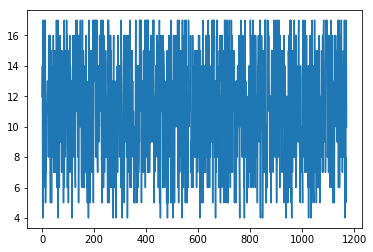

In [20]:
plt.plot(lenghs)
plt.show()

In [21]:
def greedy_decode(model, vocab, stars, sample_id):
    stars = torch.tensor(stars).unsqueeze_(0)
    sample_id = torch.tensor(sample_id).unsqueeze_(0)
    token = 'START'
    state = model.create_initial_hiddens(stars, sample_id)
    print(state[0].size())
    i = 0
    tmp = [token]
    while token != 'END':
        review = torch.full((1,1), vocab.stoi[token], dtype=torch.int64)
        
        prediction, state = model(review, state)
        token = decode_int(torch.argmax(prediction))
        tmp.append(token)
        i += 1
        if i > 200:
            print('too long!!!')
            return tmp
    return tmp

with torch.no_grad():
    decoded = greedy_decode(model, vocab, 1, 500)
    sentence_final = ' '.join(decoded)
    print(sentence_final)

AttributeError: 'NoEncoderFConvDecoderModel' object has no attribute 'create_initial_hiddens'